# Preprocess Chrome History

In [2]:
import pandas as pd 

In [3]:
chrome_history = pd.read_json('/bigtemp/ahs5ce/CS6501_Projects/Project3/raw/History.json', orient='index')

### Most common daily sites i visit

In [4]:
import json
from collections import Counter, defaultdict
from datetime import datetime
from urllib.parse import urlparse

def load_history(path):
    with open(path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return data.get('Browser History', [])

def domain_from_url(url):
    try:
        netloc = urlparse(url).netloc
        # strip port, lowercase
        return netloc.split(':')[0].lower()
    except:
        return None

def most_common_sites_daily(history, top_n=5):
    daily_counts = defaultdict(Counter)
    for entry in history:
        ts = entry.get('time_usec')
        url = entry.get('url')
        if ts and url:
            # Chrome’s time_usec is microseconds since Unix epoch
            dt = datetime.utcfromtimestamp(ts / 1e6)
            date_str = dt.date().isoformat()
            domain = domain_from_url(url)
            if domain:
                daily_counts[date_str][domain] += 1

    # For each date, return the top N domains and counts
    return {date: counts.most_common(top_n)
            for date, counts in daily_counts.items()}

history = load_history('/bigtemp/ahs5ce/CS6501_Projects/Project3/raw/History.json')
top_sites = most_common_sites_daily(history, top_n=10)
for date in sorted(top_sites):
    print(f"{date}:")
    for domain, count in top_sites[date]:
        print(f"  {domain}: {count}")

2024-04-13:
  arxiv.org: 3
  drops.dagstuhl.de: 1
  qiyanjun.github.io: 1
2024-04-14:
  arxiv.org: 157
  www.google.com: 34
  scholar.google.com: 22
  llms4science-community.github.io: 17
  huggingface.co: 14
  chat.openai.com: 13
  mail.google.com: 7
  www.overleaf.com: 3
  qiyanjun.github.io: 3
  rec.virginia.edu: 2
2024-04-15:
  arxiv.org: 241
  docs.google.com: 30
  canvas.its.virginia.edu: 19
  www.google.com: 13
  virginia.zoom.us: 6
  qiyanjun.github.io: 4
  calebziems.com: 4
  shibidp.its.virginia.edu: 4
  www.forbes.com: 3
  yumeng5.github.io: 3
2024-04-16:
  engineering.cmu.edu: 138
  mail.google.com: 52
  arxiv.org: 22
  www.doa.virginia.gov: 21
  chat.openai.com: 16
  www.google.com: 14
  github.com: 11
  qiyanjun.github.io: 5
  www.overleaf.com: 4
  www.change.org: 3
2024-04-17:
  arxiv.org: 217
  docs.google.com: 106
  openreview.net: 91
  scholar.google.com: 44
  ieeexplore.ieee.org: 25
  www.google.com: 19
  scholar.googleusercontent.com: 10
  chat.openai.com: 10
  soun

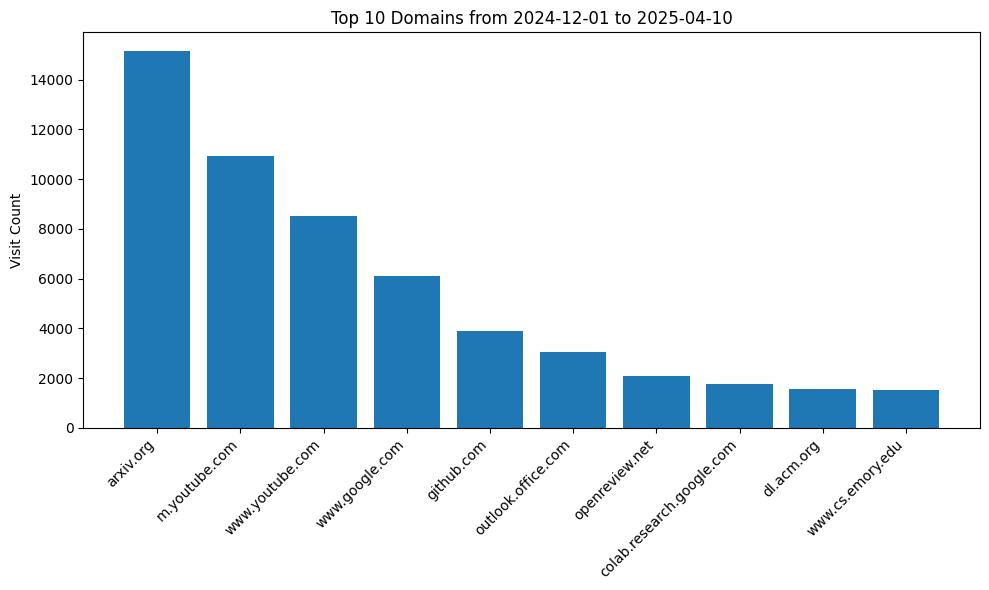

In [5]:
from datetime import datetime, date
import matplotlib.pyplot as plt

def count_domains_between(history, start_date, end_date):
    counts = Counter()
    for entry in history:
        ts = entry.get('time_usec')
        url = entry.get('url')
        if not ts or not url:
            continue

        # Convert Chrome’s microsecond timestamp to a date
        visit_date = datetime.utcfromtimestamp(ts / 1e6).date()

        # Check if in the desired range
        if start_date <= visit_date <= end_date:
            domain = domain_from_url(url)
            counts[domain] += 1

    return counts

def plot_top_domains(counts, n, start_date, end_date):
    top = counts.most_common(n)
    if not top:
        print("No visits in the specified date range.")
        return
    domains, counts_vals = zip(*top)
    plt.figure(figsize=(10, 6))
    plt.bar(domains, counts_vals)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Visit Count')
    plt.title(f'Top {n} Domains from {start_date.isoformat()} to {end_date.isoformat()}')
    plt.tight_layout()
    plt.show()

START_DATE = date(2024, 12, 1)
END_DATE   = date(2025, 4, 10)
TOP_N = 10

domain_counts = count_domains_between(history, START_DATE, END_DATE)
plot_top_domains(domain_counts, TOP_N, START_DATE, END_DATE)


In [6]:
domain_counts

Counter({'arxiv.org': 15150,
         'm.youtube.com': 10951,
         'www.youtube.com': 8528,
         'www.google.com': 6101,
         'github.com': 3888,
         'outlook.office.com': 3061,
         'openreview.net': 2079,
         'colab.research.google.com': 1765,
         'dl.acm.org': 1554,
         'www.cs.emory.edu': 1501,
         'ood.hpc.virginia.edu': 1380,
         'proceedings.neurips.cc': 1115,
         'pmc.ncbi.nlm.nih.gov': 917,
         'web.stanford.edu': 898,
         'docs.google.com': 677,
         'mail.google.com': 612,
         'ieeexplore.ieee.org': 472,
         'aclanthology.org': 415,
         'www.overleaf.com': 406,
         'drive.google.com': 371,
         'lucid.app': 362,
         'www.ijcai.org': 349,
         'wordcounts.com': 343,
         'shibidp.its.virginia.edu': 338,
         'huggingface.co': 331,
         'watermark.silverchair.com': 312,
         'tomfletcher.github.io': 290,
         'canvas.its.virginia.edu': 268,
         'anonymous.

### Most common sites I visit for life events + 1 days before hand. 
 

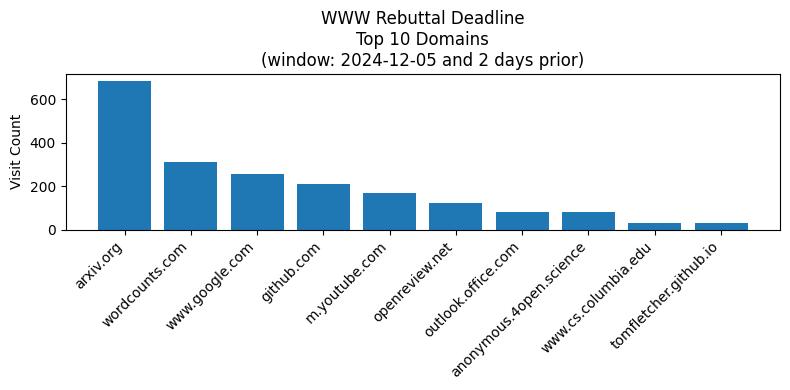

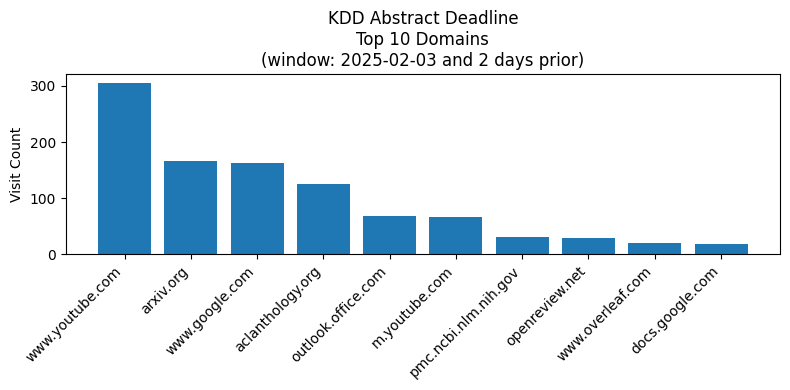

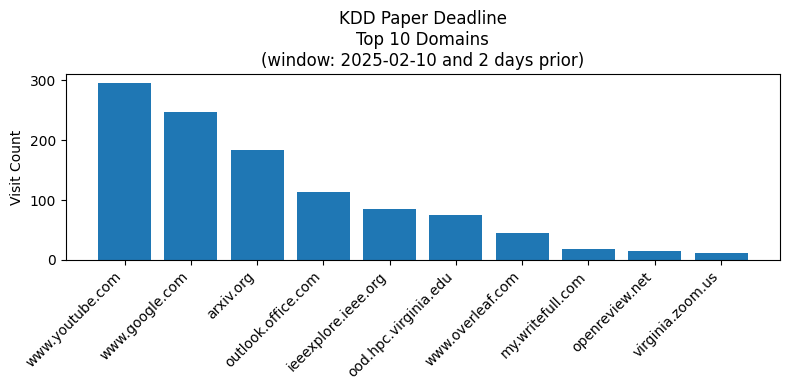

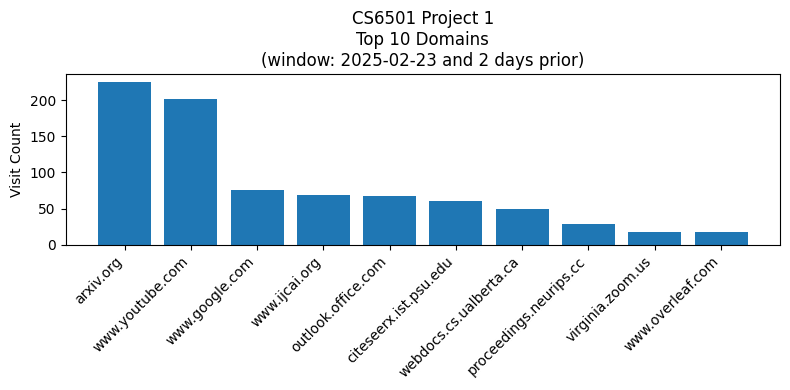

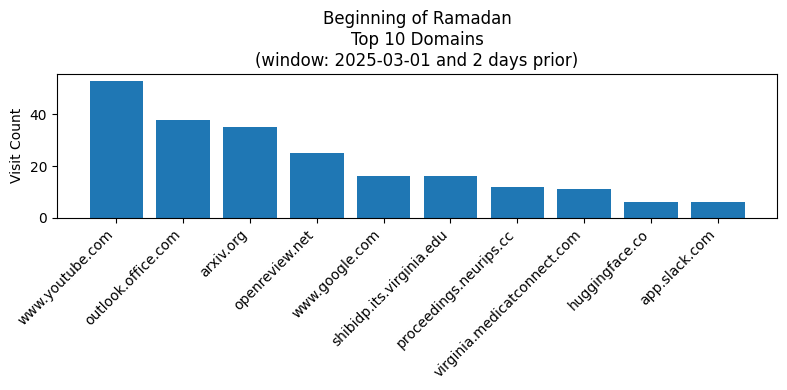

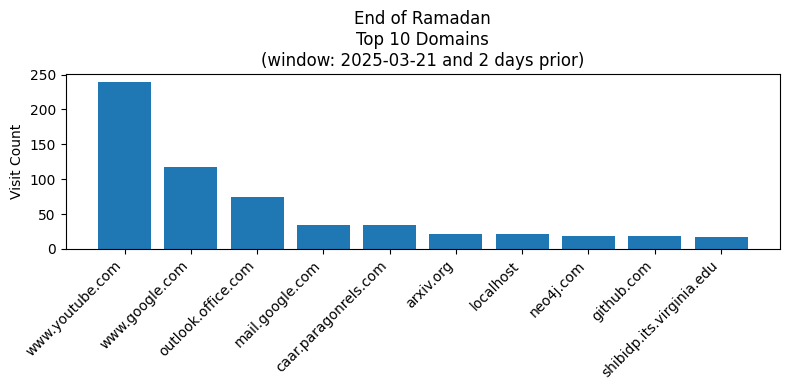

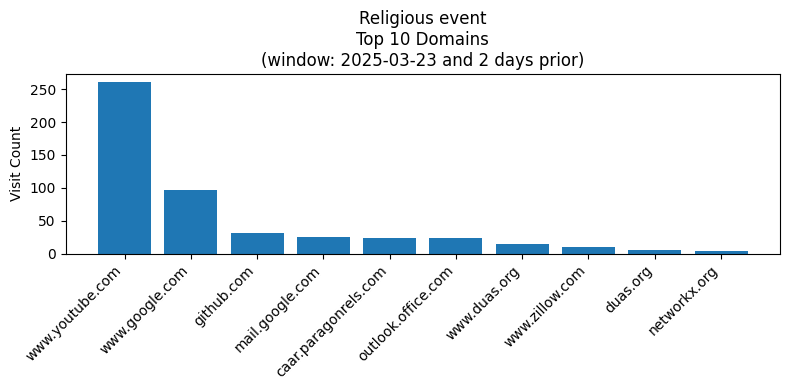

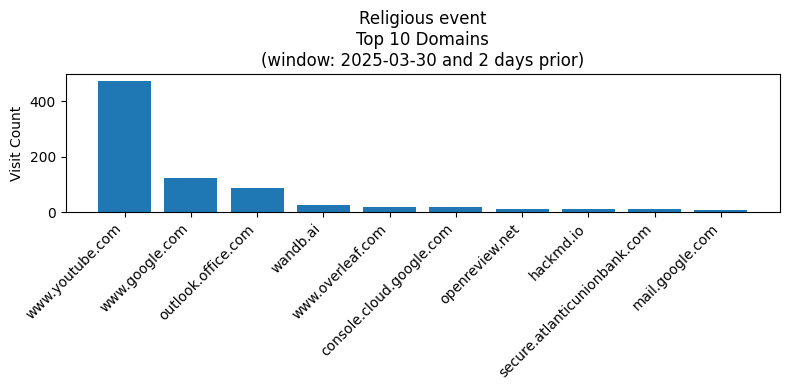

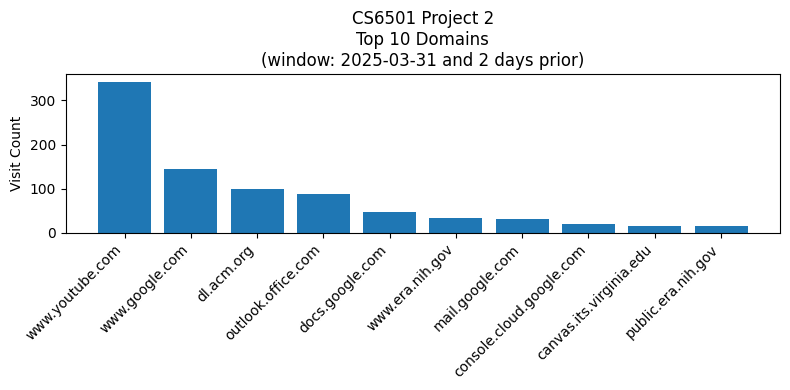

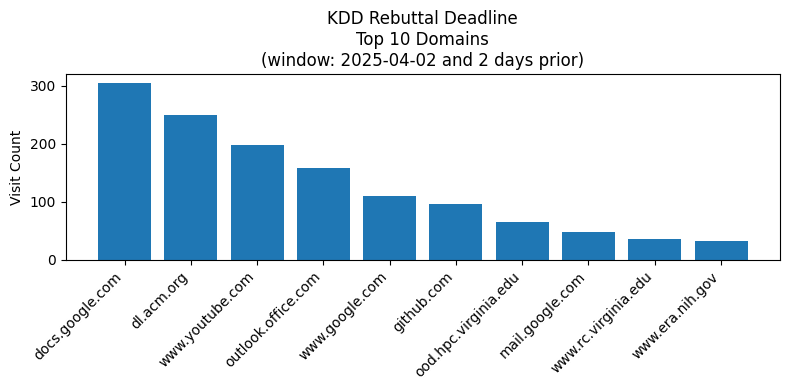

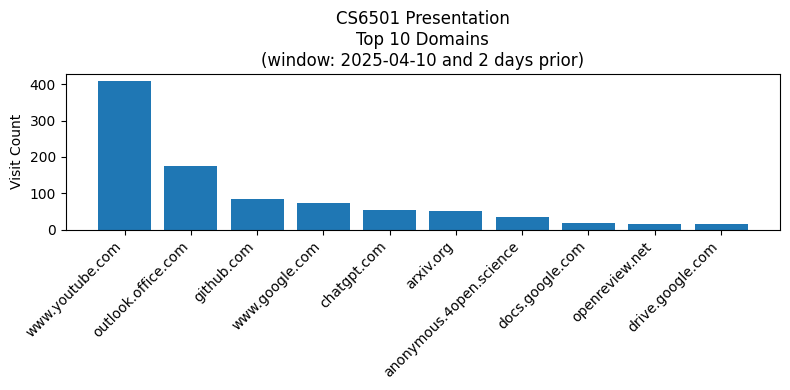

In [14]:
from datetime import datetime, timedelta, date

def most_common_sites_daily(history):
    """
    Returns a dict mapping 'YYYY-MM-DD' -> Counter(domain -> visits on that day).
    """
    daily_counts = defaultdict(Counter)
    for entry in history:
        ts = entry.get('time_usec')
        url = entry.get('url')
        if not ts or not url:
            continue
        dt = datetime.utcfromtimestamp(ts / 1e6)
        day = dt.date().isoformat()
        domain = domain_from_url(url)
        if domain:
            daily_counts[day][domain] += 1
    return daily_counts

def windowed_top_sites(daily_counts, target_dates, buffer_days=2, top_n=5):
    result = {}
    for d in target_dates:
        if isinstance(d, str):
            d = datetime.fromisoformat(d).date()
        window = [(d - timedelta(days=i)).isoformat() for i in range(buffer_days+1)]
        c = Counter()
        for day in window:
            c.update(daily_counts.get(day, Counter()))
        result[d.isoformat()] = c.most_common(top_n)
    return result

daily = most_common_sites_daily(history)

# List your target dates here:
targets = [
    date(2024, 12, 5),
    date(2025, 2, 3),
    date(2025, 2, 10),
    date(2025, 2, 23),
    date(2025, 3, 1),
    date(2025, 3, 21),
    date(2025, 3, 23),
    date(2025, 3, 30),
    date(2025, 3, 31),
    date(2025, 4, 2),
    date(2025, 4, 10),
]

event_titles = [
    "WWW Rebuttal Deadline",
    "KDD Abstract Deadline",
    "KDD Paper Deadline", 
    "CS6501 Project 1",
    "Beginning of Ramadan",
    "End of Ramadan", 
    "Religious event",
    "Religious event",
    "CS6501 Project 2",
    "KDD Rebuttal Deadline",
    "CS6501 Presentation"
]


top_n = 10

top_sites = windowed_top_sites(daily, targets, buffer_days=2, top_n=top_n)

for date_obj, title in zip(targets, event_titles):
    key = date_obj.isoformat()
    sites = top_sites.get(key, [])
    if not sites:
        print(f"No data for {title} ({key})")
        continue

    domains, counts = zip(*sites)
    plt.figure(figsize=(8, 4))
    plt.bar(domains, counts)
    plt.xticks(rotation=45, ha='right')
    plt.title(f"{title}\nTop {top_n} Domains\n(window: {key} and 2 days prior)")
    plt.ylabel("Visit Count")
    plt.tight_layout()

plt.show()

In [22]:
chrome_history = chrome_history.T
chrome_history = chrome_history['Browser History']
chrome_history = pd.DataFrame(chrome_history.tolist())
from urllib.parse import urlparse

# --- Step 1: Convert timestamps and filter by date ---
# Convert 'time_usec' to datetime
chrome_history['time_usec'] = pd.to_datetime(chrome_history['time_usec'])

# Filter to include only the last 6 months of data
six_months_ago = pd.Timestamp.now() - pd.DateOffset(months=6)
chrome_history_recent = chrome_history[chrome_history['time_usec'] >= six_months_ago].copy()

# --- Step 2: Exclude YouTube-related entries ---
# Remove rows where the URL contains 'youtube.com' or 'youtu.be'
chrome_history_recent = chrome_history_recent[~chrome_history_recent['url'].str.contains(r"youtube\.com|youtu\.be", case=False, na=False)]

# --- Step 3: Estimate session durations ---
# Sort by timestamp
chrome_history_recent = chrome_history_recent.sort_values(by='time_usec')

# Compute time differences between consecutive events
chrome_history_recent['time_diff'] = chrome_history_recent['time_usec'].diff()

# Define a threshold (e.g., 30 minutes) to cap continuous browsing gaps
threshold = pd.Timedelta(minutes=30)
chrome_history_recent['session_duration'] = chrome_history_recent['time_diff'].apply(lambda x: x if pd.notnull(x) and x <= threshold else pd.Timedelta(0))

# Create a new column for the date (dropping the time)
chrome_history_recent['date'] = chrome_history_recent['time_usec'].dt.date

# --- Step 4: Extract domain names ---
def extract_domain(url):
    try:
        parsed = urlparse(url)
        return parsed.netloc
    except Exception:
        return None

chrome_history_recent['domain'] = chrome_history_recent['url'].apply(extract_domain)

# --- Step 5: Aggregate overall daily Chrome time ---
daily_chrome_time = chrome_history_recent.groupby('date')['session_duration'].sum().reset_index()
daily_chrome_time['chrome_time_minutes'] = daily_chrome_time['session_duration'].dt.total_seconds() / 60

# --- Step 6: Compute top 5 sites per day based on time spent ---
# Group by date and domain to sum the session durations for each site
domain_daily = chrome_history_recent.groupby(['date', 'domain'])['session_duration'].sum().reset_index()
domain_daily['duration_seconds'] = domain_daily['session_duration'].dt.total_seconds()

# Define a function to extract the top 5 domains for a given date
def top_5_sites_for_date(date):
    daily_data = domain_daily[domain_daily['date'] == date]
    sorted_domains = daily_data.sort_values(by='duration_seconds', ascending=False)
    # Return a list of the top 5 domain names (if less than 5, it will return whatever is available)
    top_domains = list(sorted_domains['domain'].head(5))
    return top_domains

# Apply the function to each date
daily_chrome_time['top_5_sites'] = daily_chrome_time['date'].apply(top_5_sites_for_date)



In [24]:
chrome_history_recent

,favicon_url,page_transition_qualifier,title,url,time_usec,client_id,time_diff,session_duration,date,domain


In [ ]:
daily_chrome_time

# Preprocess YouTube History